<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Instacart" data-toc-modified-id="Instacart-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Instacart</a></span><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Product-Features" data-toc-modified-id="Product-Features-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Product Features</a></span></li><li><span><a href="#User-Features" data-toc-modified-id="User-Features-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>User Features</a></span></li><li><span><a href="#Label-&amp;-Additional-Features" data-toc-modified-id="Label-&amp;-Additional-Features-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Label &amp; Additional Features</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Scoring-/-Inference" data-toc-modified-id="Scoring-/-Inference-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Scoring / Inference</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,lightgbm

Ethen 2018-10-01 21:23:44 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.1
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2
lightgbm 2.1.0


# Instacart

The goal of this competition was to predict grocery reorders: given a user's purchase history (a set of orders, and the products purchased within each order), which of their previously purchased products will they repurchase in their next order?

The question that's interesting is the dynamics of product recommendation might be different from movie recommendation where user's preference might be relatively constant across a short period of time. e.g. For Netflix, it might be fine assuming a user want to watch another movie similar to the ones they just watched, it's less clear that, however, whether we'll want to reorder a fresh batch of almond butter or toilet paper if we bought them yesterday.

This scripts considered all the products a user has ordered and performs a binary classification on the order-product pair.

For the submission, we keep the products that have a probability of re-order higher than a threshold.

## Feature Engineering

In [2]:
def read_dataset(data_dir):
    orders_path = os.path.join(data_dir, 'orders.csv')
    orders = pd.read_csv(orders_path, dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32
    })
    print('order dimension: {}, {}; sample data:\n'.format(*orders.shape))
    print(orders.head())

    order_prior_path = os.path.join(data_dir, 'order_products__prior.csv')
    order_prior = pd.read_csv(order_prior_path, dtype={
        'order_id': np.int32,
        'product_id': np.uint16,
        'add_to_cart_order': np.int16,
        'reordered': np.int8
    })
    print('\norder_prior dimension: {}, {}; sample data:\n'.format(*order_prior.shape))
    print(order_prior.head())

    order_train_path = os.path.join(data_dir, 'order_products__train.csv')
    order_train = pd.read_csv(order_train_path, dtype={
        'order_id': np.int32,
        'product_id': np.uint16,
        'add_to_cart_order': np.int16,
        'reordered': np.int8
    })
    print('\norder_train dimension: {}, {}; sample data:\n'.format(*order_train.shape))
    print(order_train.head())

    # there's also a product name field, this excludes it
    # ?? include product name as feature
    usecols = ['product_id', 'aisle_id', 'department_id']
    products_path = os.path.join(data_dir, 'products.csv')
    products = pd.read_csv(products_path, usecols=usecols, dtype={
        'product_id': np.uint16,
        'aisle_id': np.uint8,
        'department_id': np.uint8
    })
    print('\nproducts dimension: {}, {}; sample data:\n'.format(*products.shape))
    print(products.head())

    return orders, order_prior, order_train, products


data_dir = os.path.join('..', 'all')
orders, order_prior, order_train, products = read_dataset(data_dir)

order dimension: 3421083, 7; sample data:

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

order_prior dimension: 32434489, 4; sample data:

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4    

### Product Features

In [3]:
def create_product_features(products, prior):
    """
    Add product's historical performance (based on the prior table)
    to the product table as additional features.
    """
    prod = pd.DataFrame()
    grouped = prior.groupby('product_id')
    prod['product_total_orders'] = grouped.size().astype(np.int32)
    prod['product_total_reorders'] = grouped['reordered'].sum().astype(np.int32)
    prod['product_reorder_rate'] = (prod['product_total_reorders'] /
                                    prod['product_total_orders']).astype(np.float32)

    rename_mapping = {'aisle_id' : 'product_aisle_id',
                      'department_id': 'product_department_id'}
    products = (products.join(prod, on='product_id').
                rename(rename_mapping, axis='columns'))
    return products


products = create_product_features(products, order_prior)
products.head()

,product_id,product_aisle_id,product_department_id,product_total_orders,product_total_reorders,product_reorder_rate
0,1,61,19,1852.0,1136.0,0.613391
1,2,104,13,90.0,12.0,0.133333
2,3,94,7,277.0,203.0,0.732852
3,4,38,1,329.0,147.0,0.446809
4,5,5,13,15.0,9.0,0.600000


### User Features

In [4]:
def create_user_features(orders, prior):
    """Create user level, user-order level features and user-product level features."""

    # compute user-order level features per user
    user_order = pd.DataFrame()
    grouped = orders.groupby('user_id')  # [orders['eval_set'] == 'prior']
    user_order['user_total_orders'] = grouped.size().astype(np.int16)
    user_order['user_avg_days_between_orders'] = (grouped['days_since_prior_order'].
                                                  mean().
                                                  astype(np.float32))

    # obtain a user's historical product ordering history to compute
    # user and user-product level features,
    # since we will be getting a user's last order id for a product, thus
    # we sort by the order_number to make it easier later
    user_order_product = prior[['order_id', 'product_id', 'add_to_cart_order']].merge(
        orders[['order_id', 'user_id', 'order_number']], on='order_id')
    user_order_product = user_order_product.sort_values('order_number')

    # user level features
    users = pd.DataFrame()
    grouped = user_order_product.groupby('user_id')
    users['user_total_items'] = grouped.size().astype(np.int16)
    users['user_all_products'] = grouped['product_id'].apply(set)
    users['user_total_distinct_items'] = (users['user_all_products'].map(len)).astype(np.int16)

    users = users.join(user_order)
    users['user_avg_basket_size'] = (users['user_total_items'] /
                                     users['user_total_orders']).astype(np.float32)

    # user-product level features
    # pandas's groupby preserves row ordering, since we already sorted the records
    # by the order_number, thus we can take the last record to get the last order id.
    # we can print out the record for a user id and product id to double-check
    # mask = (user_order_product['user_id'] == 154293) & (user_order_product['product_id'] == 23081)
    # user_order_product[mask]
    user_product = (user_order_product.
                    groupby(['user_id', 'product_id'], sort=False).
                    agg({'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'}))
    user_product.columns = ['UP_total_orders', 'UP_last_order_id', 'UP_sum_pos_in_cart']
    user_product = user_product.astype(
        {'UP_total_orders': np.int16, 'UP_last_order_id': np.int32, 'UP_sum_pos_in_cart': np.int16})
    user_product['UP_avg_pos_in_cart'] = (user_product['UP_sum_pos_in_cart'] /
                                          user_product['UP_total_orders']).astype(np.float32)

    return users, user_product


users, user_product = create_user_features(orders, order_prior)
users.head()

,user_total_items,user_all_products,user_total_distinct_items,user_total_orders,user_avg_days_between_orders,user_avg_basket_size
user_id,,,,,,
1,59,"{17122, 196, 26405, 14084, 46149, 26088, 13032...",18,11,19.000000,5.363636
2,195,"{45066, 2573, 18961, 1559, 32792, 23, 22559, 1...",102,15,16.285715,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,13,12.000000,6.769231
4,18,"{21573, 17769, 35469, 37646, 43704, 11865, 190...",17,6,17.000000,3.000000
5,37,"{11777, 28289, 40706, 48775, 20754, 6808, 1398...",23,5,11.500000,7.400000


In [5]:
user_product.head()

UP_total_orders  UP_last_order_id  UP_sum_pos_in_cart  \
user_id product_id                                                          
86239   6075                      1           1520399                  14   
154293  41329                     1           2049062                   3   
        23081                     3           1489630                   8   
        21527                     3           2251505                  14   
        35050                     4           2251505                  18   

                    UP_avg_pos_in_cart  
user_id product_id                      
86239   6075                 14.000000  
154293  41329                 3.000000  
        23081                 2.666667  
        21527                 4.666667  
        35050                 4.500000

### Label & Additional Features

In [6]:
def create_data_and_label(orders_eval, user_all_products, order_train=None):
    """
    The label is whether the products that the user has bought
    before (i.e. product that appeared in the prior table)
    is in the train data, since train data records the products
    that were actually bought on the next purchase.
    """
    if order_train is not None:
        # converting the order_id and product_id into a set upfront will speed up
        # the process significantly
        train_product = set(order_train.set_index(['order_id', 'product_id']).index)    

    label = []
    order_list = []
    product_list = []
    for row in orders_eval.itertuples():
        user_id = getattr(row, 'user_id')
        order_id = getattr(row, 'order_id')

        # get all the products a user has bought
        # from the prior table;
        # the user table is indexed by user_id
        user_product = user_all_products.loc[user_id]
        product_list += user_product
        order_list += [order_id] * len(user_product)

        if order_train is not None:
            label += [(order_id, product) in train_product for product in user_product]
 
    data = pd.DataFrame({'order_id': order_list, 'product_id': product_list}, dtype=np.int32)
    if order_train is not None:
        data['label'] = np.array(label, dtype=np.int8)

    return data

In [7]:
orders_eval_train = (orders[orders['eval_set'] == 'train'].
                     drop('eval_set', axis=1))
orders_eval_train.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,11,4,8,14.0
25,1492625,2,15,1,11,30.0
49,2196797,5,5,0,11,6.0
74,525192,7,21,2,11,6.0
78,880375,8,4,1,14,10.0


In [8]:
df = create_data_and_label(orders_eval_train, users['user_all_products'], order_train)

print('label distribution: ', np.bincount(df['label']) / df.shape[0])
print('dimension: ', df.shape)
df.head()

label distribution:  [0.90219975 0.09780025]
dimension:  (8474661, 3)


,order_id,product_id,label
0,1187899,17122,0
1,1187899,196,1
2,1187899,26405,1
3,1187899,14084,0
4,1187899,46149,1


In [9]:
def merge_features(df, orders_eval, products, user_product, users):
    """merge features that we've created earlier to start creating the final table."""
    df = (df.
          merge(orders_eval, on='order_id').
          merge(products, on='product_id').
          merge(users, left_on='user_id', right_index=True).
          merge(user_product, left_on=['user_id', 'product_id'], right_index=True).
          reset_index(drop=True))
    return df

In [10]:
# we no longer need 'user_all_products' after generating the labels
df = merge_features(df, orders_eval_train, products, user_product,
                    users.drop('user_all_products', axis=1))
print('dimension: ', df.shape)
df.head()

dimension:  (8474661, 22)


,order_id,product_id,label,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_aisle_id,product_department_id,...,product_reorder_rate,user_total_items,user_total_distinct_items,user_total_orders,user_avg_days_between_orders,user_avg_basket_size,UP_total_orders,UP_last_order_id,UP_sum_pos_in_cart,UP_avg_pos_in_cart
0,1187899,17122,0,1,11,4,8,14.0,24,4,...,0.675576,59,18,11,19.0,5.363636,1,431534,6,6.0
1,1187899,196,1,1,11,4,8,14.0,77,7,...,0.776480,59,18,11,19.0,5.363636,10,2550362,14,1.4
2,1187899,26405,1,1,11,4,8,14.0,54,17,...,0.441516,59,18,11,19.0,5.363636,2,2254736,10,5.0
3,1187899,14084,0,1,11,4,8,14.0,91,16,...,0.810982,59,18,11,19.0,5.363636,1,2539329,2,2.0
4,1187899,46149,1,1,11,4,8,14.0,77,7,...,0.812456,59,18,11,19.0,5.363636,3,2550362,9,3.0


In [11]:
def create_additional_features(df, orders):
    """create additional features after the big merge."""
    df['UP_order_rate'] = (df['UP_total_orders'] / df['user_total_orders']).astype(np.float32)

    # features comparing difference from the current order versus the last order
    # the rationale is that we tend to do things at relatively the same hour
    # (habit of human)
    orders_temp = (orders[['order_id', 'order_number', 'order_dow', 'order_hour_of_day']].
                   rename({'order_id': 'UP_last_order_id'}, axis='columns'))
    df = df.merge(orders_temp, on='UP_last_order_id', suffixes=('', '_y'))

    df['UP_orders_since_last_order'] = df['user_total_orders'] - df['order_number_y']
    diff = df['order_hour_of_day'] - df['order_hour_of_day_y']
    df['UP_delta_hour_vs_last_order'] = (diff.abs().
                                         apply(lambda x: min(x, 24 - x)).astype(np.int8))
    df['UP_same_dow_as_last_order'] = df['order_dow'] == df['order_dow_y']
    df = df.drop(['UP_last_order_id', 'order_number_y', 'order_dow_y', 'order_hour_of_day_y'], axis=1)

    df['days_since_prior_order_rate'] = (df['days_since_prior_order'] /
                                         df['user_avg_days_between_orders']).astype(np.float32)

    cat_cols = [
        'order_dow',
        'order_hour_of_day',
        'product_aisle_id',
        'product_department_id',
        'UP_same_dow_as_last_order']
    for cat_col in cat_cols:
        df[cat_col] = df[cat_col].astype('category')

    return df

In [12]:
df = create_additional_features(df, orders)
print('columns: ', df.columns)
print('dimension: ', df.shape)
df.head()

columns:  Index(['order_id', 'product_id', 'label', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'product_aisle_id', 'product_department_id', 'product_total_orders',
       'product_total_reorders', 'product_reorder_rate', 'user_total_items',
       'user_total_distinct_items', 'user_total_orders',
       'user_avg_days_between_orders', 'user_avg_basket_size',
       'UP_total_orders', 'UP_sum_pos_in_cart', 'UP_avg_pos_in_cart',
       'UP_order_rate', 'UP_orders_since_last_order',
       'UP_delta_hour_vs_last_order', 'UP_same_dow_as_last_order',
       'days_since_prior_order_rate'],
      dtype='object')
dimension:  (8474661, 26)


,order_id,product_id,label,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_aisle_id,product_department_id,...,user_avg_days_between_orders,user_avg_basket_size,UP_total_orders,UP_sum_pos_in_cart,UP_avg_pos_in_cart,UP_order_rate,UP_orders_since_last_order,UP_delta_hour_vs_last_order,UP_same_dow_as_last_order,days_since_prior_order_rate
0,1187899,17122,0,1,11,4,8,14.0,24,4,...,19.0,5.363636,1,6,6.0,0.090909,6,7,True,0.736842
1,1187899,10326,0,1,11,4,8,14.0,24,4,...,19.0,5.363636,1,5,5.0,0.090909,6,7,True,0.736842
2,1187899,13176,0,1,11,4,8,14.0,24,4,...,19.0,5.363636,2,12,6.0,0.181818,6,7,True,0.736842
3,1187899,41787,0,1,11,4,8,14.0,24,4,...,19.0,5.363636,1,7,7.0,0.090909,6,7,True,0.736842
4,1187899,196,1,1,11,4,8,14.0,77,7,...,19.0,5.363636,10,14,1.4,0.909091,1,0,True,0.736842


In [13]:
# final list of features that will be used
features = [
    'order_number', 'order_dow', 'order_hour_of_day',
    'days_since_prior_order', 'days_since_prior_order_rate',
    'product_aisle_id', 'product_department_id', 'product_total_orders',
    'product_total_reorders', 'product_reorder_rate',
    'user_total_items', 'user_total_distinct_items', 'user_total_orders', 
    'user_avg_days_between_orders', 'user_avg_basket_size',
    'UP_total_orders', 'UP_order_rate', 'UP_sum_pos_in_cart',
    'UP_avg_pos_in_cart', 'UP_orders_since_last_order',
    'UP_delta_hour_vs_last_order', 'UP_same_dow_as_last_order'
]
len(features)

22

## Model Training

In [14]:
# split according to order
df_train, df_val, y_train, y_val = train_test_split(
    df[features], df['label'], test_size=0.2, random_state=1234, stratify=df['label'])

In [15]:
# for gbm, set number of estimator to a large number
# and the learning rate to be a small number, we'll simply
# let early stopping decide when to stop training
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
lgb_fixed_params = {
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'silent': False,
    'metric': 'binary',
    'objective': 'binary',
    'learning_rate': 0.1,
    'num_leaves': 96,
    'max_depth': 10,
    'n_estimators': 3000,
    'colsample_bytree': 0.9,  # equivalent to feature_fraction
    'subsample': 0.95  # equivalent to bagging_fraction
}
lgb = LGBMClassifier(**lgb_fixed_params)

eval_set = [(df_train, y_train), (df_val, y_val)]
lgb_fit_params = {
    'verbose': 100,
    'eval_set': eval_set,
    'early_stopping_rounds': 5,
    'feature_name': features
}
lgb.fit(df_train, y_train, **lgb_fit_params)

Training until validation scores don't improve for 5 rounds.
[100]	training's binary_logloss: 0.243008	valid_1's binary_logloss: 0.244924
[200]	training's binary_logloss: 0.240566	valid_1's binary_logloss: 0.244326
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.240385	valid_1's binary_logloss: 0.244312


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=10, metric='binary',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3000, n_jobs=-1, num_leaves=96, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=0.95, subsample_for_bin=200000, subsample_freq=1)

In [ ]:
# refit with the full-dataset after picking the best n_estimators
# using early stopping
del df_train, y_train, df_val, y_val
del lgb_fit_params['eval_set'], lgb_fit_params['early_stopping_rounds']

lgb_fixed_params['n_estimators'] = lgb.best_iteration_
lgb = LGBMClassifier(**lgb_fixed_params)
lgb.fit(df[features], df['label'], **lgb_fit_params)

In [17]:
def get_feature_importance(lgb, threshold=1e-3):
    """
    Sort the feature importance based on decreasing order of the
    normalized gain. Features that has a normalized gain smaller
    than the specified ``threshold`` will not be returned.
    """
    booster = lgb.booster_
    importance = booster.feature_importance(importance_type='gain')
    importance /= importance.sum()
    feature_name = np.array(booster.feature_name())

    mask = importance > threshold
    importance = importance[mask]
    feature_name = feature_name[mask]
    idx = np.argsort(importance)[::-1]
    return list(zip(feature_name[idx], np.round(importance[idx], 4)))


get_feature_importance(lgb)

[('UP_orders_since_last_order', 0.3528),
 ('UP_order_rate', 0.3469),
 ('UP_total_orders', 0.1034),
 ('product_reorder_rate', 0.0451),
 ('product_aisle_id', 0.0411),
 ('days_since_prior_order', 0.0168),
 ('days_since_prior_order_rate', 0.0163),
 ('user_total_distinct_items', 0.0121),
 ('order_number', 0.0112),
 ('user_total_items', 0.0081),
 ('product_total_reorders', 0.008),
 ('user_avg_basket_size', 0.0074),
 ('order_hour_of_day', 0.0068),
 ('user_avg_days_between_orders', 0.0054),
 ('product_total_orders', 0.0053),
 ('UP_delta_hour_vs_last_order', 0.0041),
 ('UP_avg_pos_in_cart', 0.0023),
 ('UP_sum_pos_in_cart', 0.0022),
 ('order_dow', 0.0016),
 ('product_department_id', 0.0013),
 ('UP_same_dow_as_last_order', 0.0013)]

## Scoring / Inference

In [18]:
# we can re-use the function above to generate the features
# on our test set, note that we do not have the labels this time
orders_eval_test = (orders[orders['eval_set'] == 'test'].
                    drop('eval_set', axis=1))
df_test = create_data_and_label(orders_eval_test, users['user_all_products'])

df_test = merge_features(df_test, orders_eval_test, products, user_product,
                         users.drop('user_all_products', axis=1))
df_test = create_additional_features(df_test, orders)

print('dimension: ', df_test.shape)
df_test.head()

dimension:  (4833292, 25)


,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_aisle_id,product_department_id,product_total_orders,...,user_avg_days_between_orders,user_avg_basket_size,UP_total_orders,UP_sum_pos_in_cart,UP_avg_pos_in_cart,UP_order_rate,UP_orders_since_last_order,UP_delta_hour_vs_last_order,UP_same_dow_as_last_order,days_since_prior_order_rate
0,2774568,17668,3,13,5,15,11.0,91,16,2110.0,...,12.0,6.769231,5,18,3.60,0.384615,2,3,False,0.916667
1,2774568,43961,3,13,5,15,11.0,123,4,55371.0,...,12.0,6.769231,4,15,3.75,0.307692,2,3,False,0.916667
2,2774568,44683,3,13,5,15,11.0,83,4,22275.0,...,12.0,6.769231,2,19,9.50,0.153846,7,1,False,0.916667
3,2774568,48523,3,13,5,15,11.0,37,1,5129.0,...,12.0,6.769231,2,13,6.50,0.153846,4,1,False,0.916667
4,2774568,16797,3,13,5,15,11.0,24,4,142951.0,...,12.0,6.769231,3,12,4.00,0.230769,4,1,False,0.916667


In [19]:
preds = lgb.predict_proba(df_test[features])
preds

array([[0.64442376, 0.35557624],
       [0.66414802, 0.33585198],
       [0.93445731, 0.06554269],
       ...,
       [0.75528583, 0.24471417],
       [0.44534574, 0.55465426],
       [0.1088886 , 0.8911114 ]])

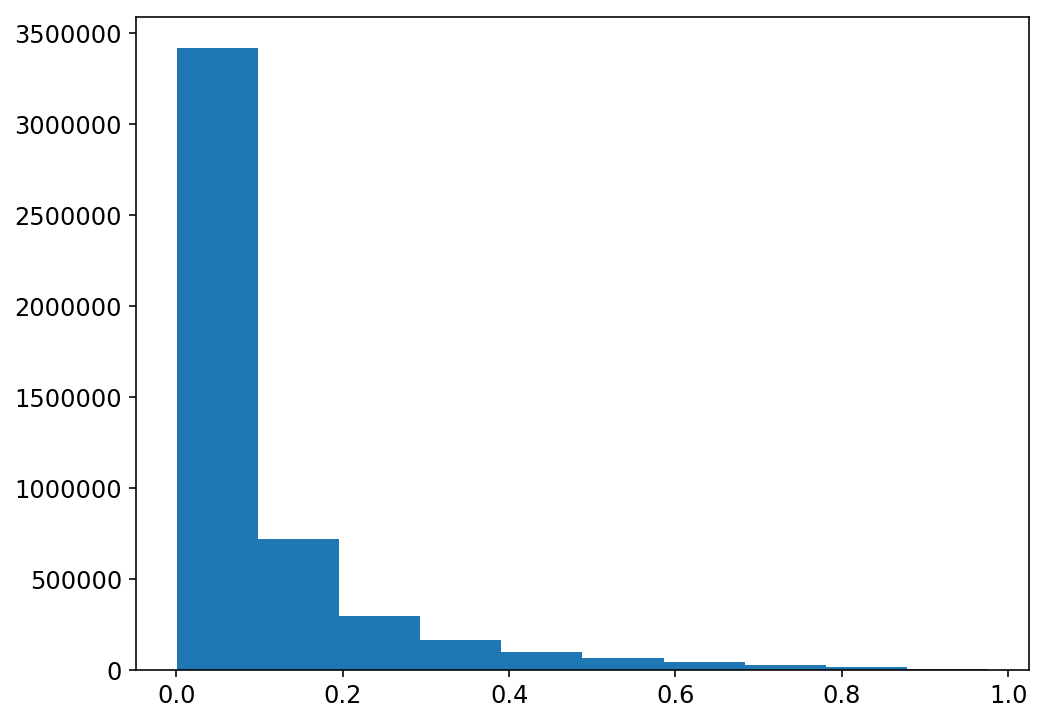

In [20]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# distribution of the predicted probability
plt.hist(preds[:, 1])
plt.show()

In [24]:
def create_submission(df, order_id, threshold):
    """Items with scores higher than this threshold will be recommended."""
    
    sub = {}
    for row in df.itertuples():
        if row.pred > threshold:
            try:
                sub[row.order_id] += ' ' + str(row.product_id)
            except:
                sub[row.order_id] = str(row.product_id)

    for order in order_id:
        if order not in sub:
            sub[order] = 'None'

    sub = pd.DataFrame.from_dict(sub, orient='index').reset_index(drop=False)
    sub.columns = ['order_id', 'products']
    return sub

In [27]:
# guess, should be tuned with crossval on a subset of train data
THRESHOLD = 0.21
df_test['pred'] = preds[:, 1]
sub = create_submission(df_test[['order_id', 'product_id', 'pred']],
                        orders_eval_test['order_id'], THRESHOLD)
print('dimension: ', sub.shape)
sub.head()

dimension:  (75000, 2)


,order_id,products
0,2774568,17668 43961 21903 39190 47766 18599 23650 24810
1,65467,44910 24852 35140 28204 1511 432 36735 47630
2,1530394,22035 47209 11520 22963 5212 38557 29370 48415...
3,505397,17668 47766 4217 24852 40310 33754 29091 25199...
4,1347920,21903 18370 17948 4605 10246 15290 18027 17872...


In [28]:
# this gets us around a F1 score of 0.377
sub.to_csv('sub.csv', index=False)

http://blog.kaggle.com/2017/09/21/instacart-market-basket-analysis-winners-interview-2nd-place-kazuki-onodera/

- Can't have a Kaggle competition without ensembling multiple models. The winner ensembled multiple XGBoost model each with a slightly different parameter (e.g. a different random seed or learning rate).
- Some of the winner's top important features. The suffix "n5" means "near5", i.e., features extracted from the 5 most recent orders.
    - `total_buy_n5(User A, Item B)` is the total number of times User A bought Item B out of the 5 most recent orders.
    - `total_buy_ratio_n5` is the proportion of A's 5 most recent orders in which A bought B.
    - `useritem_order_days_max_n5`, Captures the longest that A has recently gone without buying B.
    - `order_ratio_by_chance_n5` captures the proportion of recent orders in which A had the chance to buy B, and did indeed do so. (A "chance" refers to the number of opportunities the user had for buying the item after first encountering it. For example, if a user A had order numbers 1-5, and bought item B at order number 2, then the user had 4 chances to buy the item, at order numbers 2, 3, 4, and 5.)
    - `useritem_order_days_median_n5` is the median number of days that A has recently gone without buying B.
- Different orders should have different thresholds.


- https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/38112
- https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/38100

# Reference

- https://www.kaggle.com/paulantoine/light-gbm-benchmark-0-3692